In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
from PIL import Image
from data.utils import show_random

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adadelta

Using TensorFlow backend.


# Read the data: morphological labels

Labels, assigned visually by astronomers in the GAMA collaboration:

In [4]:
morph = pd.read_csv(os.path.join("data","morphology.txt"), sep=" ")

There are two distinct labels, with no info on self-consistency: HubbleType and isElliptical

In [5]:
morph.head()

,id,HubbleType,isElliptical
0,6802,Sd-Irr,NotElliptical
1,6821,Sd-Irr,NotElliptical
2,6826,-,LBS
3,6844,-,Elliptical
4,6974,-,Elliptical


2451 galaxies do not have a HubbleType:

In [6]:
morph.HubbleType.value_counts()

Sd-Irr     2698
-          2451
Sab-Scd    1200
LBS         623
E           613
S0-Sa       571
Name: HubbleType, dtype: int64

In [7]:
morph.isElliptical.value_counts()

NotElliptical    4676
Elliptical       2688
LBS               792
Name: isElliptical, dtype: int64

# Process the labels

Our goal will be to develop a model which can predict a correct label given a galaxy image.

Let's focus on predicting the `isElliptical` label, and take a random sample of 2500 galaxies with the label "Elliptical" and 2500 with the label "NotElliptical".  We will also need to select the corresponding images.

In [8]:
mask = morph.isElliptical == "NotElliptical"
df0 = morph[mask].sample(2500, random_state=0)
df0.head()

,id,HubbleType,isElliptical
3201,240205,Sd-Irr,NotElliptical
407,37051,Sd-Irr,NotElliptical
1924,138468,LBS,NotElliptical
4784,362282,Sab-Scd,NotElliptical
1139,79862,Sd-Irr,NotElliptical


In [9]:
mask = morph.isElliptical == "Elliptical"
df1 = morph[mask].sample(2500, random_state=0)
df1.head()

,id,HubbleType,isElliptical
5316,388513,-,Elliptical
8038,3878589,-,Elliptical
6161,511892,E,Elliptical
5190,381227,E,Elliptical
1214,91328,-,Elliptical


Merge the data frames and check it is sensible:

In [10]:
data = pd.concat( (df0,df1) )

In [11]:
data.isElliptical.value_counts()

Elliptical       2500
NotElliptical    2500
Name: isElliptical, dtype: int64

Create an array of integer labels, i.e. convert the string labels 'Elliptical' and 'NotElliptical' to integers

In [12]:
labdict = { 'NotElliptical':0, 'Elliptical':1 }
labels = np.array( [ labdict[s] for s in data.isElliptical ] )

# Read the data: galaxy images

Read the images associated with our subset of the label data (with IDs lining up row by row)

In [13]:
loa = [ np.array( Image.open(os.path.join("data","images","{}_giH.png").format(i)), dtype=np.uint8 ) for i in data.id ]
images = np.array( loa )

There are 5000 total images, and each one has size 28x28x3 pixels:

In [14]:
images.shape

(5000, 28, 28, 3)

Currently, the image data is stored as integer values in the range of 0 to 255.  For machine learning applications, we need to rescale this data to the range 0 to 1 and convert to float.

In [ ]:
print( images.min(), images.max() )

In [ ]:
images = np.float32(images)/255.

In [ ]:
print( images.min(), images.max() )

# Inspect the data

To recap, our data has been processed into two numpy arrays: `images` and `labels`.

Let's look at some random galaxies in the dataset along with their label (0=NotElliptical, 1=Elliptical)

In [ ]:
show_random(images, labels )

# Build the CNN

In [15]:
images.shape[1:]

(28, 28, 3)

In [16]:
def build( input_shape=images.shape[1:], num_classes=len(np.unique(labels)) ):
    # note the input shape is simply the shape of 'x' without the first dimension = (50,50,1)
    # i.e. the number of datapoints in the training set does not matter
        
    model = Sequential()
    
    # Layers:
    model.add(Conv2D(3, input_shape=input_shape, kernel_size=(3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(3, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(4, (2, 2), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    #model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.5))
    
    # Final layer (fully connected)
    if num_classes == 2:
        model.add( Dense(1, activation='sigmoid') )
        model.compile( optimizer=Adadelta(), loss=binary_crossentropy, metrics=['accuracy'] )
    elif num_classes > 2:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=Adadelta(), loss=categorical_crossentropy, metrics=['accuracy'])
    
    return model

In [17]:
model = build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 3)         84        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 3)         84        
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 4)         52        
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2116)              0         
__________

# Train the model

Be sure to reserve some of the data for validation

In [18]:
model = build()
history = model.fit( images, labels, batch_size=128, epochs=30, verbose=1, validation_split=0.2 )

# Watch as the training accuracy begins at 50% and slowly climbs to around 90%.  Validation accuracy is similar.

Train on 4000 samples, validate on 1000 samples
Epoch 1/30
4000/4000 [==============================] - 5s 1ms/step - loss: 2.5123 - acc: 0.6022 - val_loss: 0.8835 - val_acc: 0.3760
Epoch 2/30
4000/4000 [==============================] - 4s 1ms/step - loss: 0.7096 - acc: 0.6150 - val_loss: 0.8354 - val_acc: 0.3350
Epoch 3/30
4000/4000 [==============================] - 5s 1ms/step - loss: 0.6174 - acc: 0.6345 - val_loss: 0.8291 - val_acc: 0.3430
Epoch 4/30
4000/4000 [==============================] - 4s 1ms/step - loss: 0.5950 - acc: 0.6465 - val_loss: 0.8644 - val_acc: 0.3540
Epoch 5/30
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5734 - acc: 0.6660 - val_loss: 0.7430 - val_acc: 0.5020
Epoch 6/30
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5509 - acc: 0.6873 - val_loss: 0.8023 - val_acc: 0.4660
Epoch 7/30
4000/4000 [==============================] - 5s 1ms/step - loss: 0.5183 - acc: 0.7570 - val_loss: 0.7453 - val_acc: 0.7660
Epoch 8/30
400

# Plot the training history 

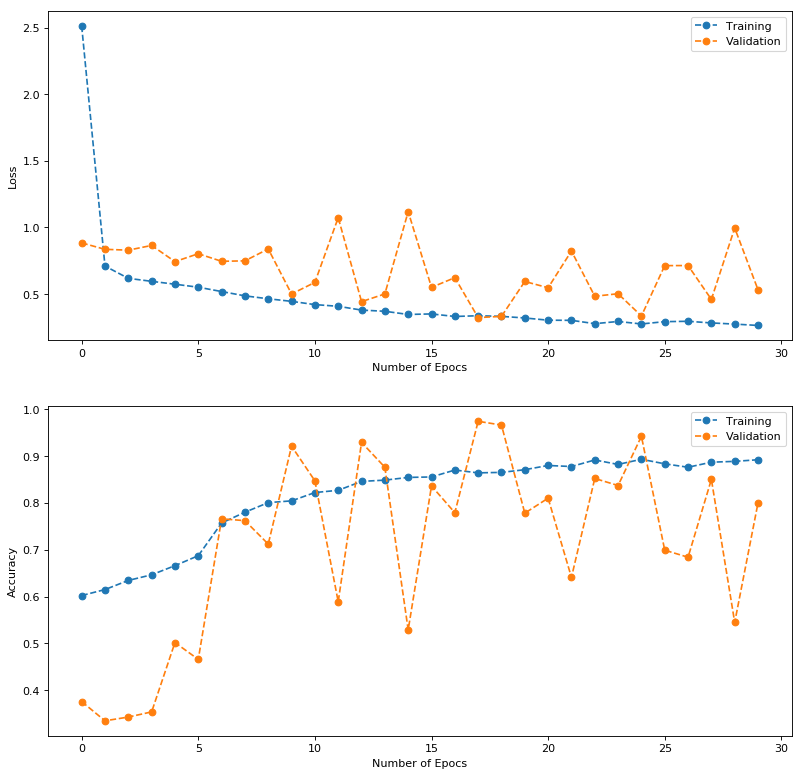

In [19]:
import matplotlib.pyplot as plt
import pylab
history_dict = history.history

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), dpi= 80)

ax1.plot(history_dict['loss'], 'o--', label='Training')
ax1.plot(history_dict['val_loss'], 'o--', label='Validation')
ax1.set_xlabel('Number of Epocs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(history_dict['acc'], 'o--', label='Training')
ax2.plot(history_dict['val_acc'], 'o--', label='Validation')
ax2.set_xlabel('Number of Epocs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Inspect the predictions

- The predictions are probabilities between 0 and 1 that the given galaxy is an Elliptical.

In [ ]:
predictions = model.predict( images )[:,0]   # need to subset to get the correct shape

In [ ]:
predictions

In [ ]:
show_random(images, labels, predictions)

## Your turn:
- confusion matrix
- plot the distribution of predicted probabilities for each class
- plot which images are misclassified; develop intuition for improving the model
- consider tweaking the architecture, e.g. see how different Conv2D or Dropout or MaxPooling affects the result

- the dataframe you loaded has more granular data, i.e. the HubbleType. See if you can implement a CNN to predict more than one class
